In [2]:
## Run this to Setup the Environment
import cv2 as cv
from matplotlib import pyplot as plt
import os
import numpy as np
import random as rng
rootPath = 'D:/AMEP lab/BBot Database'

In [17]:
"""
  DO NOT RUN THIS IF FRAMES ALREADY LOADED! IT TAKES LONG!
  This part of the code is for writing the input video into frames
"""
print(os.getcwd())
print(os.listdir())

cap = cv.VideoCapture(rootPath+'/input/videos/bot2run5.MOV')
if (cap.isOpened()== False):
  print("Error opening video stream or file")

# Frame number called flag
flag = 0
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    flag+=1
    cv.imwrite(rootPath+"/input/frames/bot2run5/"+str(flag)+".jpg", frame)
  # Break the loop
  else:
    break

d:\AMEP lab\BBot Database\scripts
['data analysis with bot2run4.ipynb', 'Simulation with Cicconofri & DeSimone model.ipynb', 'video analysis with bot1.ipynb', 'video analysis with bot2.ipynb', 'video analysis with bot2run1.ipynb', 'video processing with bot2run5.ipynb', 'video_processing_with_bot2run4.ipynb']


In [18]:
def dynamicMask(frame, initialPixelValue):
    """
    Masks the frame according to the ellipse that we are drawing, continue to increase masking value until 
    there is only one or less ellipse from the getEllipseFrom() Function

    returns the masked image and ellipse
    ellipse is either None or One ellipse object, see GetEllipseFrom()
    """
    mask = initialPixelValue
    while mask < 256:
        masked = frame.copy()
        masked = np.where(frame > mask, 255, masked)
        masked = np.where(frame < mask, 0, masked)
        ellipse = GetEllipseFrom(masked)
        if len(ellipse) > 1:
            mask += 1
            continue
        else:
            return [masked, ellipse]

def convertToDisplay(frame):
    """
    This function helps you arrange the data output of cv.imread() which is in BGR format
    into RGB format which is the input format of plt.imshow()

    It takes a cv Mat variable and returns a np.array()
    """
    converted = np.zeros((frame.shape[0], frame.shape[1], frame.shape[2]), dtype=np.int16)
    global blues, greens, reds
    for ri, row in enumerate(frame):
        for pi, pixel in enumerate(row):
            converted[ri][pi] = [pixel[2], pixel[1], pixel[0]]
            reds += [pixel[2]]
            blues += [pixel[0]]
            greens += [pixel[1]]
    return converted

def GetEllipseFrom(frame): #frame must be a np.array()
  """
  Returns an ellipse object
  locate the robot object in the frame and identifies it with a minimum area ellipse around it
  
  """

  frame = frame.astype('uint8')
  frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

  #plt.imshow(frame)
  #Find all the contours in this frame
  contours,_= cv.findContours(image=frame,
                              mode=cv.RETR_TREE,
                              method=cv.CHAIN_APPROX_NONE,
                             )

  #Find out all the ellipse corresponding to the contours in this frame:
  minEllipse = [None]*len(contours)
  for i,c in enumerate(contours):
    if c.shape[0] > 5:
      minEllipse[i] = cv.fitEllipse(c)

  return minEllipse

In [19]:
# Store all frames as binary frames to a .npy file
# MASK IT!
path = rootPath+"/input/frames/bot2run5" #REMEMBER: path has to use '/' instead of '\'
background = cv.imread(path+'/1.jpg')

numberOfFrames = len(os.listdir(path))
center = np.zeros((numberOfFrames,2))
size = np.zeros((numberOfFrames,2))
angle = np.zeros((numberOfFrames,1))

for i in range(numberOfFrames):
    robot = cv.imread(path+'/{}.jpg'.format(i+1)) # Configure this according to the directory
    robotOnly = cv.subtract(robot, background) # Subtract background from robot, leaving only the robot image, otherwise black
    robotBinary = cv.GaussianBlur(robotOnly,(11,11),0) # Blur the image. This is Tunable parameter

    _, minEllipse = dynamicMask(robotBinary, 10)

    # Putting all the variables where they belong, indexing may create problems, but in general 
    # try-except block captures all the data
    #TODO: Need to look more into this part, since there might be signals missing because of this
    #      brute-force processing
    try:
        center[i] = minEllipse[0][0]
        size[i] = minEllipse[0][1]
        angle[i] = minEllipse[0][2]
    except:
        center[i] = (-1, -1)
        size[i] = (-1, -1)
        angle[i] = [-1]
    print('Finished Working on Frame_{}'.format(i+1))

path = rootPath+'/output/data/bot2run5/center.npy'
np.save(path, np.asarray(center))
path = rootPath+'/output/data/bot2run5/size.npy'
np.save(path, size)
path = rootPath+'/output/data/bot2run5/angle.npy'
np.save(path, angle)

Finished Working on Frame_1
Finished Working on Frame_2
Finished Working on Frame_3
Finished Working on Frame_4
Finished Working on Frame_5
Finished Working on Frame_6
Finished Working on Frame_7
Finished Working on Frame_8
Finished Working on Frame_9
Finished Working on Frame_10
Finished Working on Frame_11
Finished Working on Frame_12
Finished Working on Frame_13
Finished Working on Frame_14
Finished Working on Frame_15
Finished Working on Frame_16
Finished Working on Frame_17
Finished Working on Frame_18
Finished Working on Frame_19
Finished Working on Frame_20
Finished Working on Frame_21
Finished Working on Frame_22
Finished Working on Frame_23
Finished Working on Frame_24
Finished Working on Frame_25
Finished Working on Frame_26
Finished Working on Frame_27
Finished Working on Frame_28
Finished Working on Frame_29
Finished Working on Frame_30
Finished Working on Frame_31
Finished Working on Frame_32
Finished Working on Frame_33
Finished Working on Frame_34
Finished Working on Fra

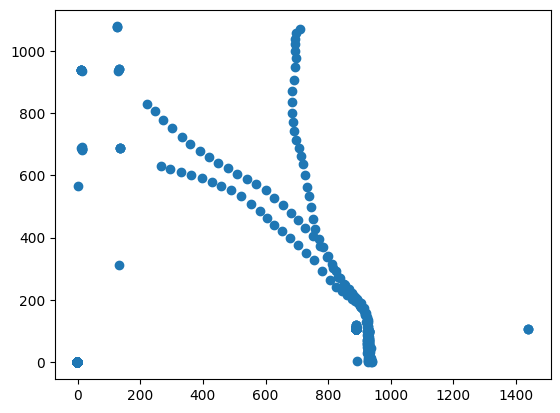

In [20]:
plt.scatter([c[0] for c in center], [c[1] for c in center])

In [11]:
def setOfVariables(vars, fullRobot):
    # produce a set of variable of the robot divided based on the different times
    # when the robot has walked the experiment
    # fullRobot, an array of [True, False] that indicates
    # which frame has a full-length robot present
    Set = [[] for _ in range(0,10)]
    flag = -1
    for i, c in enumerate(vars):
        if fullRobot[i]:
            if fullRobot[i+1] and not fullRobot[i-1]:
                flag += 1
            Set[flag] += [c]
    Set = [x for x in Set if x != []]
    return Set

def getSins(pos):
    #Getting Orientation only from position data
    # Get it in radians, the same as the angle data
    sins = [[] for _ in range(len(pos))]
    for j, p in enumerate(pos):
        for i in range(len(p)-1):
            deltax = p[i+1][0] - p[i][0]
            deltay = p[i+1][1] - p[i][1]
            tan = deltax/deltay
            sins[j] += [np.sin(np.arctan(tan))]
    return sins

def getAngles(angle):
    # Input: the angles generated by getEllipse function in the video processing stage
    # Output: sin() of the angles in a numpy array
    angles = angle.copy()
    for i, a in enumerate(angles):
        if a < 100:
            angles[i] = a + 180
    angles = np.array([a*np.pi/180 for a in angles])
    np.sin(angles, out=angles)
    return angles

#plt.plot([s[1] for s in size])# UNCOMMENT TO CHECK WHICH FRAME HAS A ROBOT
fullRobot = np.array([s[1] for s in size]) > 250
#fullRobot = the array of boolean values 
#that contains all the information about which frame has robot and which not

pos = setOfVariables(center, fullRobot)
sins = getSins(pos)

angles = setOfVariables(getAngles(angle), fullRobot)

for i, s in enumerate(sins):
    plt.plot([x for x in s], label = 'translational-walk {}'.format(i+1))

for i, a in enumerate(angles):
    plt.plot([x for x in a], label = 'non-translational-walk {}'.format(i+1))
    plt.xlabel('frame')
    plt.ylabel('$\\sin\\theta$')
plt.legend()

NameError: name 'angle' is not defined

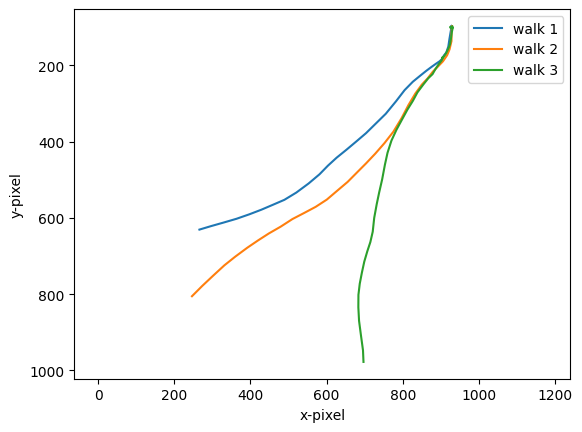

In [12]:
fig, ax = plt.subplots()
for i, p in enumerate(pos):
    ax.plot([px[0] for px in p], [py[1] for py in p], label = 'walk {}'.format(i+1))
ax.invert_yaxis()
ax.set_aspect('equal')
ax.axis('equal')
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
plt.legend()

